# 결정 트리를 이용한 사용자 행동 인식(Human Activity Recognition) 데이터 예측 분류

- UCI 머신러닝 리포지토리에서 제공
- http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

# 데이터 설명

- 30명에게 스마트폰 센서를 장착한 뒤 사람의 동작과 관련된 여러 가지 피처를 수집한 데이터

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 dataframe으로 로드
feature_name_df = pd.read_csv('./human_activity/features.txt', sep = '\s+', header = None,
                              names = ['column_index', 'column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출: ', feature_name[:10])

전체 피처명에서 10개만 추출:  ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [2]:
# features.txt파일은 중복된 피처명을 가지고 있으므로 이를 제거해야 함

# 먼저, 중복된 피처명이 얼마나 있는지 확인
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


- 총 42개의 피처명 중복
- 중복된 피처명에 대해 원본 피처명에 _1 또는 _2를 추가로 부여해 새로운 피처명을 가지는 dataframe을 반환하는 함수 생성

In [5]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(), columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how = 'outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 
                                                              'dup_cnt']].apply(lambda x: x[0] + '_' + str(x[1])
                                                                               if x[1] > 0 else x[0], axis = 1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis = 1)
    return new_feature_name_df

In [6]:
import pandas as pd

def get_human_dataset():
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep = '\s+', header = None,
                                  names = ['column_index', 'column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용해서 신규 피처명 dataframe 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # dataframe에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 세트와 테스트 피처 데이터를 dataframe으로 로딩. 칼럼명은 feature_name 적용
    x_train = pd.read_csv('./human_activity/train/X_train.txt', sep = '\s+', names = feature_name)
    x_test = pd.read_csv('./human_activity/test/X_test.txt', sep = '\s+', names = feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 dataframe으로 로딩. 칼럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep = '\s+', header = None, names = ['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep = '\s+', header = None, names = ['action'])
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = get_human_dataset()

In [7]:
print('## 학습 피처 데이터셋 info ##')
print(x_train.info())

## 학습 피처 데이터셋 info ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


- 학습 데이터 세트는 7352개의 레코드로 561개의 피처를 가지고 있음
- 피처는 전부 float형의 숫자형 칼럼

In [9]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

- 레이블 값은 1, 2, 3, 4, 5, 6으로 특정값에 치우치지 않고 고르게 분포

In [11]:
# DecisionTreeClassifier를 이용해 동작 예측 분류 수행

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state = 156)
dt_clf.fit(x_train, y_train)
pred = dt_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터: \n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터: 
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


- 약 85.48%의 정확도

In [12]:
# max_depth 값을 변화하면서 예측 성능 확인

from sklearn.model_selection import GridSearchCV

params = {'max_depth' : [6, 8, 10, 12, 16, 20, 24], 'min_samples_split' : [16]}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_split': 16}


- max_depth = 8일 때 5개의 폴드 세트의 최고 평균 정확도 결과가 약 85.49%로 나옴
- 5개의 cv세트에서 max_depth 값에 따라 어떻게 예측 성능이 변했는지 다음 코드에서 확인

In [13]:
# GridSearchCV 객체의 cv_results_ 속성은 CV세트에 하이퍼 파라미터를 순차적으로 입력헀을 때의 성능 수치를 갖고 있음

cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth파라미터 값과 그때의 테스트 세트, 학습 데이터 세트의 정확도 수치 축출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.847662
1,8,0.854879
2,10,0.852705
3,12,0.845768
4,16,0.847127
5,20,0.848624
6,24,0.848624


- max_depth = 8일 때 0.854로 정확도가 가장 높고, 그 이후에는 정확도가 계속 감소함

In [14]:
# 테스트 데이터 세트에서 결정 트리의 정확도 측정

max_depths = [6, 8, 10, 12, 16, 20, 24]

# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth = depth, min_samples_split = 16, random_state = 156)
    dt_clf.fit(x_train, y_train)
    pred = dt_clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth, accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


- max_depth = 8일 경우 약 87.17%로 가장 높은 정확도를 보임
- 그 이후에는 정확도가 감소함

In [15]:
# max_depth, min_samples_split을 같이 변경하면서 정확도 성능 튜닝

params = {'max_depth' : [8, 12, 16, 20],
          'min_samples_split' : [16, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 1)
grid_cv.fit(x_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_split': 16}


- max_depth = 8, min_samples_split = 16일 때 가장 최고의 정확도로 약 85.49%를 나타냄

In [17]:
# 테스트 데이터 세트에 위에서 나온 최적의 하이퍼 파라미터 적용

best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(x_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

결정 트리 예측 정확도: 0.8717


- 최적 하이퍼 파라미터 적용 결과 테스트 데이터 세트의 예측 정확도 = 약 87.17%

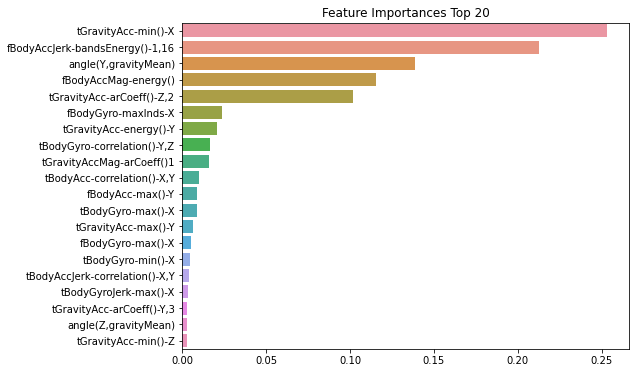

In [18]:
# 결정 트리에서 각 피처의 중요도 확인

import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_

# top중요도로 정렬을 쉽게 하고, seaborn의 막대그래프로 쉽게 표현하기 위해 series 변환
ftr_importances = pd.Series(ftr_importances_values, index = x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending = False)[:20]
plt.figure(figsize = (8, 6))
plt.title('Feature Importances Top 20')
sns.barplot(x = ftr_top20, y = ftr_top20.index)
plt.show()